# Jun 18th, 2022 (boot parallel: 128)

**Motivation**: Full of grabage, but still could be useful <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 14, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

# gr_ca = Group(**props_ca).fit_group()
# gr_bo = Group(**props_bo).fit_group()

In [4]:
from analysis.bootstrap import BootStrap

In [5]:
boot = BootStrap(**props_ca)

In [6]:
self = boot

### None SciPy vs SciPy

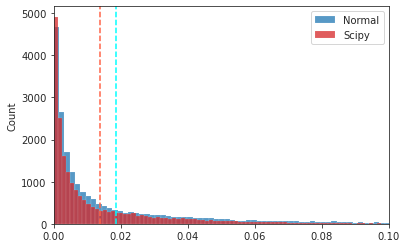

In [7]:
se, f = self.fit_boot(True, False)
sns.histplot(se[np.isfinite(se)], label='Normal')
plt.axvline(bn.nanmean(se), color='cyan', ls='--')

se, f = self.fit_boot(True, True)
sns.histplot(se[np.isfinite(se)], label='Scipy', color='C3')
plt.axvline(bn.nanmean(se), color='tomato', ls='--')
plt.xlim(0., 0.10)
plt.legend()
plt.show()

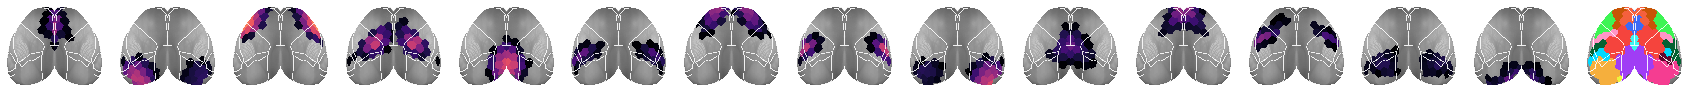

In [8]:
_ = self.show(avg(self.run_pi), figsize=(30, 6))

In [9]:
%%time

pi_prune = self.prune(use_scipy=True)

CPU times: user 2h 44min 47s, sys: 6min 7s, total: 2h 50min 54s
Wall time: 6min 25s


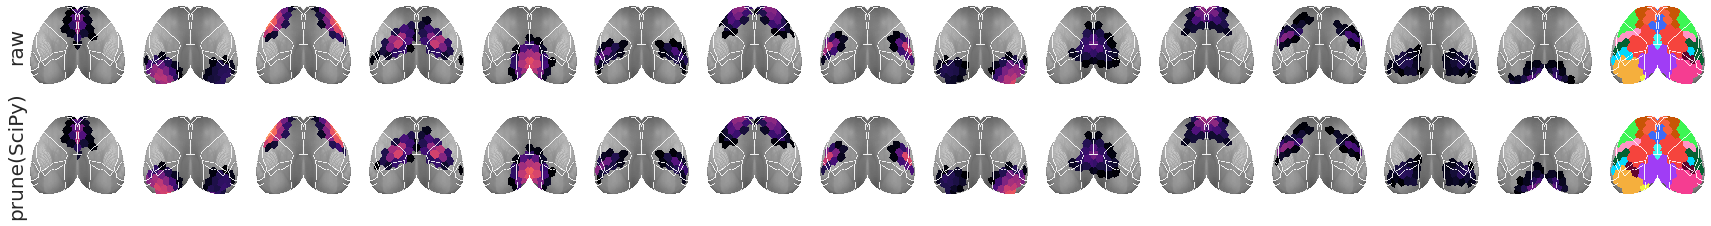

In [10]:
_ = self.show({'raw': avg(self.run_pi), 'prune(SciPy)': avg(pi_prune)}, figsize=(30, 3.7), ylabel_fontsize=20)

In [11]:
self.pi_symmetry_score(avg(pi_prune))

(
    {
        1: 0.985,
        2: 0.98,
        3: 0.99,
        4: 0.989,
        5: 0.995,
        6: 0.973,
        7: 0.985,
        8: 0.983,
        9: 0.917,
        10: 0.99,
        11: 0.98,
        12: 0.985,
        13: 0.965,
        14: 0.959,
        -1: 0.977
    },
    {
        1: 0.987,
        2: 0.803,
        3: 1.0,
        4: 0.987,
        5: 0.987,
        6: 0.974,
        7: 1.0,
        8: 0.961,
        9: 0.789,
        10: 1.0,
        11: 0.987,
        12: 0.974,
        13: 0.974,
        14: 0.974,
        -1: 0.957
    }
)

In [12]:
self.pi_symmetry_score(avg(self.run_pi))

(
    {
        1: 0.983,
        2: 0.981,
        3: 0.991,
        4: 0.989,
        5: 0.997,
        6: 0.987,
        7: 0.984,
        8: 0.978,
        9: 0.938,
        10: 0.993,
        11: 0.986,
        12: 0.987,
        13: 0.97,
        14: 0.927,
        -1: 0.978
    },
    {
        1: 0.987,
        2: 0.789,
        3: 1.0,
        4: 0.987,
        5: 1.0,
        6: 0.961,
        7: 1.0,
        8: 0.961,
        9: 0.789,
        10: 1.0,
        11: 0.987,
        12: 0.974,
        13: 0.974,
        14: 0.987,
        -1: 0.957
    }
)

In [ ]:
self.pi_symmetry_score(avg(self.run_pi))

In [14]:
reshape_runs = True

In [25]:
n_runs = self.get_anim_num_runs()
data_all, good_nodes = {}, {}
for i in range(self.mice.cfg.n_subjects):
    x = self.run_pi[i]
    if reshape_runs:
        x = x.reshape((-1, *x.shape[-3:]))

        nans = np.isnan(x).sum(-1).sum(-1)
        nans = nans == np.prod(x.shape[-2:])
        good_runs = np.where(nans.sum(-1) < nans.shape[-1])[0]
        assert len(good_runs) == n_runs[self.mice.get_key(i + 1)]

        x = x[good_runs]
        nans = nans[good_runs]
        good_seeds = np.where(nans.sum(0) < len(good_runs))[0]
        if len(good_seeds) < x.shape[-3]:
            x = x[:, good_seeds]

        nans = np.isnan(x).sum(0).sum(0).sum(0)
        good = np.where(nans < np.prod(x.shape[:3]))[0]
        data_all[i] = x[..., good]
        good_nodes[i] = good

In [62]:
i = 1
x = self.run_pi[i]
x.shape

(3, 4, 245, 14, 152)

In [63]:
good = np.isnan(avg(x)).sum(0) == 0
x = x[..., good]

nans = np.isnan(x).sum(-1).sum(-1) == np.prod(x.shape[-2:])
nans = nans.reshape(-1, nans.shape[-1])
good_seeds = nans.sum(0) < np.prod(x.shape[:2]) // 2
if good_seeds.sum() < x.shape[-3]:
    x = x[:, :, good_seeds]

good_seeds.sum(), good.sum(), x.shape

(163, 150, (3, 4, 163, 14, 150))

In [64]:
x.shape

(3, 4, 163, 14, 150)

<matplotlib.image.AxesImage object at 0x7fc58951b070>

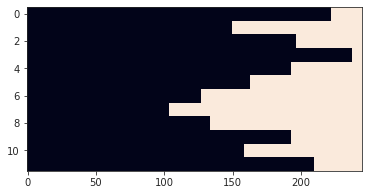

In [61]:
plt.imshow(nans, aspect=10)

<matplotlib.image.AxesImage object at 0x7fc5491dfb50>

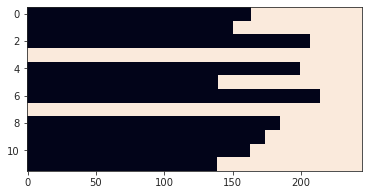

In [65]:
plt.imshow(nans, aspect=10)

In [66]:
nans.sum(0)

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12])

### waiting for results of BCa with runs not reshaped.  Will find out soon if it was hierarchicality that was leading to se normal > se BCA or what?

Expect: boot BCa with runs not reshaped will result in higher SE than se-BCa_indiv-pi_1.0e+04(runs_reshaped).npy

In [32]:
len(good_nodes[9])

151

### Observe: run reshaped vs not reshaped doesnt matter
---
---

In [67]:
se_run = np.load(pjoin(boot.path, 'se-BCa_indiv-pi_1.0e+04(runs_reshaped).npy'))
se_ses = np.load(pjoin(boot.path, 'se-BCa_indiv-pi_1.0e+04(sess).npy'))

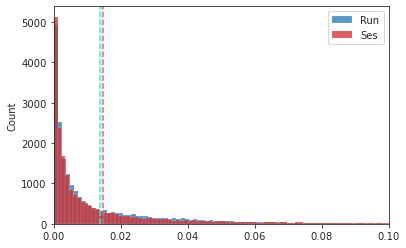

In [68]:
sns.histplot(se_run[np.isfinite(se_run)], label='Run')
plt.axvline(bn.nanmean(se_run), color='cyan', ls='--')

sns.histplot(se_ses[np.isfinite(se_ses)], label='Ses', color='C3')
plt.axvline(bn.nanmean(se_ses), color='tomato', ls='--')
plt.xlim(0., 0.10)
plt.legend()
plt.show()

### End Observe
---
---

In [38]:
se1000 = np.load(pjoin(boot.path, 'se_indiv-pi_9.0e+02.npy'))
se2 = np.load(pjoin(boot.path, 'se_indiv-pi_1.0e+03.npy'))

<matplotlib.lines.Line2D object at 0x7fabb372ef70>

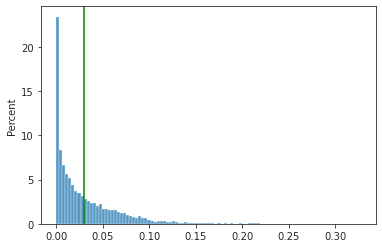

In [39]:
sns.histplot(se1000.ravel(), stat='percent',  bins=100)
plt.axvline(bn.nanmean(se1000), color='g')

<matplotlib.lines.Line2D object at 0x7fabb3753910>

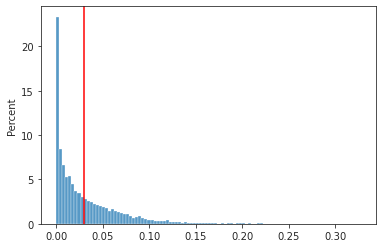

In [40]:
sns.histplot(se2.ravel(), stat='percent', bins=100)
plt.axvline(bn.nanmean(se2), color='r')

In [41]:
reject, pvals2 = boot.ttest(se2)
(reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum())

0.5131578947368421

In [42]:
reject, pvals1 = boot.ttest(se1000, multi='fdr_bh')
(reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum())

0.5121240601503759

In [43]:
pi = boot.run_pi

In [44]:
reject, pvals1 = boot.ttest(se1000, multi='fdr_bh')
print((reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()))

reject = np.expand_dims(np.expand_dims(np.expand_dims(
    reject, 1), 1), 1)
for i in range(1, 4):
    reject = np.repeat(reject, pi.shape[i], axis=i)
pi_prune = pi.copy()
pi_prune[reject == 0] = 0.0
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune, _ = self.align_post_prune(pi_prune)

0.5121240601503759

In [45]:
reject, _ = boot.ttest(se2, multi='fdr_bh')
print((reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()))

reject = np.expand_dims(np.expand_dims(np.expand_dims(
    reject, 1), 1), 1)
for i in range(1, 4):
    reject = np.repeat(reject, pi.shape[i], axis=i)
pi_prune_old = pi.copy()
pi_prune_old[reject == 0] = 0.0
pi_prune_old /= np.nansum(pi_prune_old, -2, keepdims=True)
pi_prune_old, _ = self.align_post_prune(pi_prune_old)

0.5131578947368421

In [13]:
boot.pi_symmetry_score(avg(pi_prune))

(
    {
        1: 0.985,
        2: 0.98,
        3: 0.99,
        4: 0.989,
        5: 0.995,
        6: 0.973,
        7: 0.985,
        8: 0.983,
        9: 0.917,
        10: 0.99,
        11: 0.98,
        12: 0.985,
        13: 0.965,
        14: 0.959,
        -1: 0.977
    },
    {
        1: 0.987,
        2: 0.803,
        3: 1.0,
        4: 0.987,
        5: 0.987,
        6: 0.974,
        7: 1.0,
        8: 0.961,
        9: 0.789,
        10: 1.0,
        11: 0.987,
        12: 0.974,
        13: 0.974,
        14: 0.974,
        -1: 0.957
    }
)

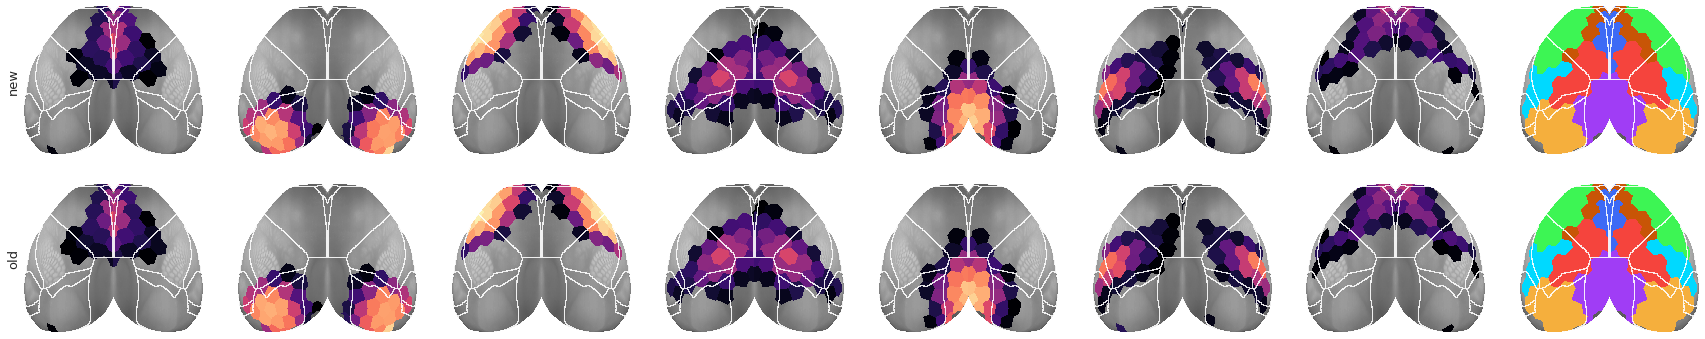

In [48]:
_ = boot.show(
    data={'new': avg(pi_prune), 'old': avg(pi_prune_old)},
    figsize=(30, 6),
    
)

14

In [17]:
cut = cut_data(
    pi_prune.reshape(-1, *pi_prune.shape[-2:]),
    bins=np.linspace(0.2, 1, 5),
    oc_only=True,
)[0].reshape(*pi_prune.shape[:4], self.num_k, -1)
cut_avg = avg(cut)
cut_avg.shape

(14, 4)

In [18]:
cut_avg[:, -1]

array([27.36537098, 32.80569461, 37.89690133, 10.82120779, 26.20854811,
       15.3394011 , 20.59212502, 29.21108632, 27.09148962,  7.64831639,
       20.06307865, 17.9432819 ,  9.63296096, 20.91084201])

In [19]:
100 - cut_avg[:, -1]

array([72.63462902, 67.19430539, 62.10309867, 89.17879221, 73.79145189,
       84.6605989 , 79.40787498, 70.78891368, 72.90851038, 92.35168361,
       79.93692135, 82.0567181 , 90.36703904, 79.08915799])

(0.0, 100.0)

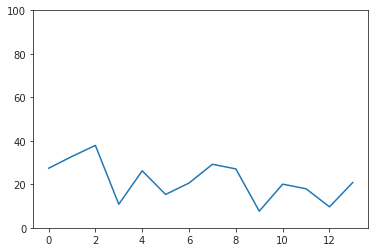

In [20]:
plt.plot(cut_avg[:, -1])
plt.ylim(0, 100)

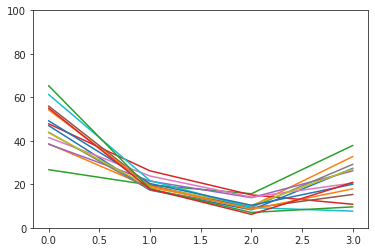

In [21]:
plt.plot(cut_avg.T)
plt.ylim(0, 100);

In [22]:
mice.cfg.n_subjects

10

In [32]:
cut = cut_data(
    pi_prune_old.reshape(-1, *pi_prune_old.shape[-2:]),
    bins=np.linspace(0.2, 1, 5),
    oc_only=True,
)[0].reshape(*pi_prune_old.shape[:4], 7, -1)
cut_avg = avg(cut)
cut_avg.shape

(7, 4)

In [33]:
cut_avg[:, -1]

array([31.53173028, 54.29026816, 62.88205079, 21.27447815, 44.26374719,
       38.24233249, 30.07890666])

In [34]:
100 - cut_avg[:, -1]

array([68.46826972, 45.70973184, 37.11794921, 78.72552185, 55.73625281,
       61.75766751, 69.92109334])

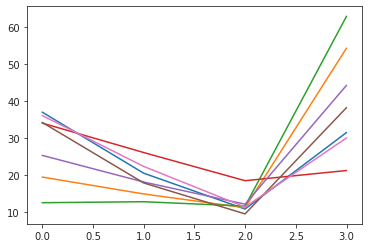

In [35]:
plt.plot(cut_avg.T);

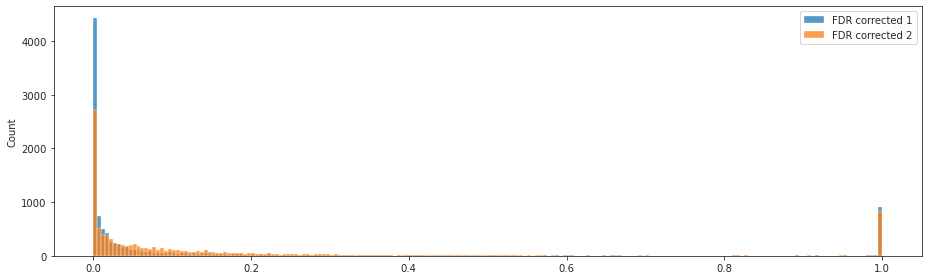

In [36]:
fig, ax = create_figure(1, 1, figsize=(13, 4))
sns.histplot(pvals1.ravel(), bins=np.linspace(0, 1, 201), color='C0', label='FDR corrected 1')
sns.histplot(pvals2.ravel(), bins=np.linspace(0, 1, 201), color='C1', label='FDR corrected 2')
plt.legend()
plt.show()

In [95]:
%%time

bbb = bootstrap(
    x=boot.run_pi,
    n_resamples=int(1e3),
    statistic=lambda a: avg(a, 2, 2),
    skip=['d0'],
    dims=4,
)
se2 = bn.nanstd(bbb, 0, ddof=1)
bbb.shape, se2.shape

CPU times: user 10min 4s, sys: 2min 2s, total: 12min 7s
Wall time: 12min 31s


((1000, 10, 7, 542), (10, 7, 542))

In [ ]:
n_runs = boot.get_anim_num_runs()

In [ ]:
# for i in range(mice.cfg.n_subjects)

i = 2
x = boot.run_pi[i]
x = x.reshape((-1, *x.shape[-3:]))
x.shape

In [ ]:
nans = np.isnan(x).sum(-1).sum(-1)
nans = nans == np.prod(x.shape[-2:])
good_runs = np.where(nans.sum(-1) < nans.shape[-1])[0]
assert len(good_runs) == n_runs[mice.get_key(i + 1)]

x = x[good_runs]
nans = nans[good_runs]
good_seeds = np.where(nans.sum(0) < len(good_runs))[0]
if len(good_seeds) < x.shape[-3]:
    x = x[:, good_seeds]
x.shape

In [ ]:
len(good_runs), len(good_seeds)

In [ ]:
self = boot

In [ ]:
n_runs = self.get_anim_num_runs()
data_all = []
for i in range(self.mice.cfg.n_subjects):
    x = self.run_pi[i]
    x = x.reshape((-1, *x.shape[-3:]))

    nans = np.isnan(x).sum(-1).sum(-1)
    nans = nans == np.prod(x.shape[-2:])
    good_runs = np.where(nans.sum(-1) < nans.shape[-1])[0]
    assert len(good_runs) == n_runs[self.mice.get_key(i + 1)]

    x = x[good_runs]
    nans = nans[good_runs]
    good_seeds = np.where(nans.sum(0) < len(good_runs))[0]
    if len(good_seeds) < x.shape[-3]:
        x = x[:, good_seeds]
    data_all.append(x)

In [ ]:
len(data_all)

In [272]:
len(weird)

50

In [151]:
x = np.random.rand(10, 3, 4, 250, 7, 154)

In [152]:
def mk_statistic(dims: int = 3, est: Callable = bn.nanmean):
    def statistic(x, axis):
        y = avg(x, x.ndim - dims, 0)
        y = est(y, axis=axis)
        print(axis, x.shape, y.shape)
        return y
    return statistic

In [153]:
data = x # bn.nanmean(x, -3)

b = sp_stats.bootstrap(
    data=(data,),
    statistic=mk_statistic(data.ndim - 3),
    n_resamples=53,
    batch=20,
    method='BCa',
    confidence_level=0.95,
    random_state=42,
    vectorized=True,
    axis=0,
)

-1
(3, 4, 250, 7, 154, 20, 10)
(7, 154, 20)

-1
(3, 4, 250, 7, 154, 20, 10)
(7, 154, 20)

-1
(3, 4, 250, 7, 154, 13, 10)
(7, 154, 13)

-1
(3, 4, 250, 7, 154, 10)
(7, 154)

-1
(3, 4, 250, 7, 154, 10, 9)
(7, 154, 10)

In [154]:
data.shape, b.standard_error.shape

((10, 3, 4, 250, 7, 154), (7, 154))

In [ ]:
data = x

b = sp_stats.bootstrap(
    data=(data,),
    statistic=mk_statistic(data.ndim - 3),
    n_resamples=53,
    batch=20,
    method='BCa',
    confidence_level=0.95,
    random_state=42,
    vectorized=True,
    axis=0,
)

In [ ]:
data.shape, b.standard_error.shape

In [ ]:
anim = 5
x_indiv = x[anim].reshape((-1, *x.shape[-3:]))
x_indiv.shape

In [ ]:
b = sp_stats.bootstrap(
    data=(x_indiv,),
    statistic=mk_statistic(x_indiv.ndim - 3),
    n_resamples=53,
    batch=20,
    method='BCa',
    confidence_level=0.95,
    random_state=42,
    vectorized=True,
    axis=0,
)

In [ ]:
x_indiv.shape, b.standard_error.shape

In [274]:
i = 6

weird = np.where(np.isnan(se1000[i]).sum(0) == 7)[0]

In [275]:
len(weird)

13

array([  0,   2,   4,   5,   6,  11,  12,  20,  21,  27,  29,  39,  40,
        45,  46,  52,  55,  60,  64,  65,  78,  79,  89, 111, 123, 126,
       136, 137, 140, 154, 155, 172, 184, 195, 202, 211, 220, 233, 249,
       254, 272, 275, 291, 300, 520, 527, 532, 536, 539, 541])

<AxesSubplot:ylabel='Count'>

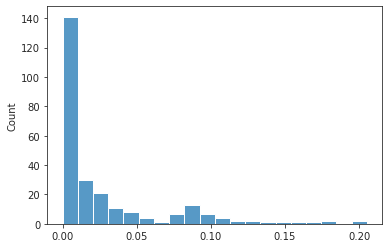

In [161]:
sns.histplot(se2[i][:, weird].ravel())

In [165]:
np.unravel_index(np.nanargmax(se2[i][:, weird]), (7, len(weird)))

(6, 43)

In [166]:
weird[43]

300

<AxesSubplot:ylabel='Count'>

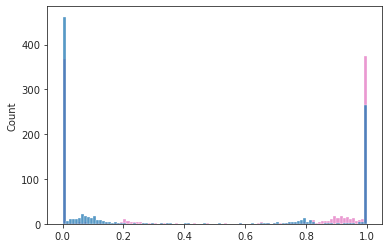

In [181]:
sns.histplot(boot.run_pi[6, ..., 300][..., 0].ravel(), bins=np.linspace(0, 1, 101), color='C6')
sns.histplot(boot.run_pi[6, ..., 300][..., 6].ravel(), bins=np.linspace(0, 1, 101))

In [182]:
se1000[i, :, 300]

array([nan, nan, nan, nan, nan, nan, nan])

In [183]:
se2[i, :, 300]

array([0.19551545, 0.00151039, 0.00968913, 0.02433845, 0.02460421,
       0.00666748, 0.20526483])

In [192]:
aaa = boot.run_pi[6, ..., 300]
aaa = aaa.reshape(-1, 250, 7, 1)
aaa.shape

(12, 250, 7, 1)

In [283]:
def mk_statistic(
        dims: int = 3,
        est: Callable = bn.nanmean, ) -> Callable:
    def statistic(x, axis):
        x = avg(x, x.ndim - dims, 0)
        x = est(x, axis=axis)
        x[np.isnan(x)] = est(x)
        print(x.shape)
        return x
    return statistic

In [284]:
b = sp_stats.bootstrap(
    data=(aaa,),
    statistic=mk_statistic(aaa.ndim - 3),
    random_state=42,
    n_resamples=1000,
    batch=50,
    vectorized=True,
    method='BCa',
    axis=0,
)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1, 50)

(7, 1)

(7, 1, 12)

In [285]:
b.standard_error.shape

(7, 1)

In [286]:
b.standard_error

array([[0.16156361],
       [0.01337514],
       [0.01443772],
       [0.01887557],
       [0.02185881],
       [0.01337757],
       [0.16416953]])

In [288]:
se2[i, :, 300]

array([0.19551545, 0.00151039, 0.00968913, 0.02433845, 0.02460421,
       0.00666748, 0.20526483])

In [223]:
bn.nanmean(b.standard_error)

nan

In [228]:
nans = np.isnan(aaa).sum(-1).sum(-1)
nans.shape

(12, 250)

In [249]:
nans.sum(1)

array([   0, 1750, 1750, 1750,    0,    0,    7, 1750, 1750, 1750, 1750,
       1750])

<matplotlib.image.AxesImage object at 0x7f08ac532130>

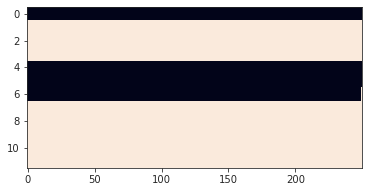

In [253]:
plt.imshow(nans, aspect=10)

In [256]:
x = self.run_pi[i]
x = x.reshape((-1, *x.shape[-3:]))

In [257]:
nans = np.isnan(x).sum(-1).sum(-1)
nans = nans == np.prod(x.shape[-2:])
good_runs = np.where(nans.sum(-1) < nans.shape[-1])[0]
assert len(good_runs) == n_runs[self.mice.get_key(i + 1)]

In [258]:
x = x[good_runs]
nans = nans[good_runs]

x.shape, nans.shape

((12, 250, 7, 542), (12, 250))

In [261]:
good_seeds = np.where(nans.sum(0) < len(good_runs))[0]
if len(good_seeds) < x.shape[-3]:
    x = x[:, good_seeds]
    
len(good_seeds)

250

In [262]:
nans.sum(0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  3,  5,  6, 10])

<matplotlib.image.AxesImage object at 0x7f08ac0919a0>

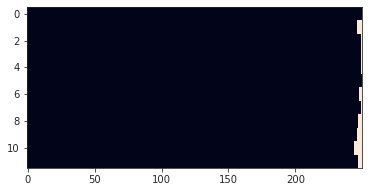

In [260]:
plt.imshow(nans, aspect=10)

In [ ]:




    x = x[good_runs]
    nans = nans[good_runs]
    good_seeds = np.where(nans.sum(0) < len(good_runs))[0]
    if len(good_seeds) < x.shape[-3]:
        x = x[:, good_seeds]

    nans = np.isnan(x).sum(0).sum(0).sum(0)
    good = np.where(nans < np.prod(x.shape[:3]))[0]
    data_all.append(x[..., good])
    good_nodes.append(good)

In [255]:
good

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  41,  42,  43,
        44,  45,  47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387,
       388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504,
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
       518, 519, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
       533, 534, 535, 536, 537, 538, 539, 540, 541])